In [1]:
import json
from config import *
from typing import cast
from openai import OpenAI
from typing import TypedDict, List, Dict, Optional
from langgraph.graph import StateGraph, START, END

from pathlib import Path
from pptx import Presentation
from pptx.util import Inches, Pt

In [2]:
class SlideGenState(TypedDict, total=False):
    user_prompt: str
    slides_outline: List[str]
    slides_content: List[Dict]  # {title_text, text:[...], image_desc?}
    output_format: str  # "pptx" | "pdf"
    output_path: str
    errors: List[str]

In [3]:
os.getenv("DASHSCOPE_API_KEY")

'sk-45ea06ec63ef4dfdac58569b8e920175'

In [4]:
client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)  # 或者连接你自己的客户端

PLAN_PROMPT = """
你是一个幻灯片创建者。根据提示，输出一个幻灯片的JSON数组。
每个幻灯片：{" title_text ": " ... ", " text ": [" • ... ", " • ... "], " image_desc ": "可选"}。
第一个元素可以是标题幻灯片，包含'title_text'和可选的'subtitle_text'。保持项目符号简洁（每个 <= 12个字）。
"""


def plan_slides_node(state: SlideGenState) -> SlideGenState:
    messages = [
        {"role": "system", "content": "Return ONLY valid JSON."},
        {"role": "user", "content": f"{PLAN_PROMPT}\n\nPrompt:\n{state['user_prompt']}"}
    ]
    resp = client.chat.completions.create(model="qwen-plus", messages=messages, temperature=0.3)
    raw = resp.choices[0].message.content
    try:
        slides = json.loads(raw)
    except Exception as e:
        state.setdefault("errors", []).append(f"JSON parse error: {e}")
        slides = [{"title_text": "Untitled", "text": []}]
    state["slides_content"] = cast(List[Dict], slides)
    state["slides_outline"] = [s.get("title_text", "") for s in slides]
    return state

In [5]:
def fill_content_node(state: SlideGenState) -> SlideGenState:
    outline = state.get("slides_outline", [])
    enriched = []
    for title in outline:
        if not title.strip():
            continue
        r = client.chat.completions.create(
            model="qwen-plus",
            messages=[{
                "role": "user",
                "content": f"Create 3–5 crisp bullets for slide '{title}'. "
                           f"Keep under 12 words, no fluff.\nContext:\n{state['user_prompt']}"
            }],
            temperature=0.4
        )
        bullets = [b.strip("• ").strip() for b in r.choices[0].message.content.split("\n") if b.strip()]
        enriched.append({"title_text": title, "text": bullets})
    state["slides_content"] = enriched or state.get("slides_content", [])
    return state

In [6]:
def build_slides_node(state: SlideGenState) -> SlideGenState:
    slides = state.get("slides_content", [])
    prs = Presentation()  # or Presentation("template.pptx")
    # Title slide
    if slides:
        title = slides[0]
        s0 = prs.slides.add_slide(prs.slide_layouts[0])
        s0.shapes.title.text = title.get("title_text", "")
        try:
            s0.placeholders[1].text = title.get("subtitle_text", "")
        except IndexError:
            pass

    # Content
    for slide in slides[1:] if slides else []:
        s = prs.slides.add_slide(prs.slide_layouts[1])
        s.shapes.title.text = slide.get("title_text", "")
        tf = s.placeholders[1].text_frame
        tf.clear()
        for bullet in slide.get("text", []):
            p = tf.add_paragraph()
            p.text = bullet
            p.level = 0
            p.font.size = Pt(20)
        # Optional images
        for img in slide.get("img_path", []) if slide.get("img_path") else []:
            s.shapes.add_picture(img, left=Inches(0.5), top=Inches(3), height=Inches(2.5))

    out = Path("output")
    out.mkdir(exist_ok=True)
    file = out / "deck_output.pptx"
    prs.save(file.as_posix())
    state["output_path"] = file.as_posix()
    return state

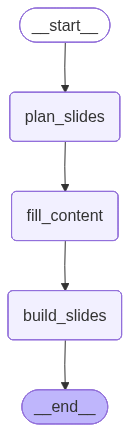

In [7]:
workflow = StateGraph(SlideGenState)
workflow.add_node("plan_slides", plan_slides_node)
workflow.add_edge(START, "plan_slides")
workflow.add_node("fill_content", fill_content_node)
workflow.add_edge("plan_slides", "fill_content")
workflow.add_node("build_slides", build_slides_node)
workflow.add_edge("fill_content", "build_slides")
workflow.add_edge("build_slides", END)
graph = workflow.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
result = graph.invoke({
    "user_prompt": "介绍人工智能的基础知识，包括定义、历史、主要技术和应用领域。"})